# Trunk Motion Validation Analysis

This notebook performs validation of IMU trunk motion data against 3D motion capture (MOCAP) data.

It includes:
- Preprocessing for one example subject
    - Visualization of trunk tilt angles
    - Visualization of raw magnetometer and gyro data
- Validation analysis over all subjects
- Normality tests
- Export of validation metrics to Excel

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import functions as mf
import pingouin as pg
from scipy.spatial.transform import Rotation as R

## Setup Subjects

Change the following parameters to fit your own data:
- tests: the name of the tests in your dataset files
- subjects_pro: the name of the elite athlete subjects that you measured, which is also how the datafiles should be called
- test_date_pro: the date on which the athletes were measured
- speeds: the two speed conditions for the test, here ls = low speed, hs = high speed
- rigid_bodies: the placements of the IMUs used during testing, here back, lower back ('low_back'), and the back of the chair
- dir: the directory on your computer where the datafiles of the IMU and 3D MOCAP are located

In [2]:
# Fill in the name of the tests
tests = ['figure8', 'intermittentsprint', 'pivot', 'slalom', 'starmove', 'straightpush', 'trunkmovement', 'uturn']

# Fill in the names of the measured subjects
subjects_all = ['Aag', 'Danique', 'Holly', 'Iza', 'Jeske', 'Rienk', 'Lotte','Boris', 'Fee', 'Floris', 'Hidde', 'Rinske', 'Vigo', 'Yinhu']
subjects_pro = ['Boris', 'Fee', 'Floris', 'Hidde', 'Rinske', 'Vigo', 'Yinhu']

# Test dates
test_date_amateur = '02.13'
test_date_pro = '03.21'

# Speeds
speeds = ['ls', 'hs']

# IMUs / rigid bodies to analyse
rigid_bodies = ['back', 'low_back', 'chair']  

# Fill in directory of where the data is stored
dir = '/Users/aagdebruijn/Library/CloudStorage/OneDrive-Persoonlijk/STUDIE/Master/Afstuderen/Master thesis/Python/data'

## Example One Subject

Perform spatial alignment of IMU and 3D MOCAP data for one subject

In [3]:
# Example subject settings
test_date = test_date_pro
subject = 'Boris'
test_name = 'trunkmovement'
speed = 'ls'
rigid_body = 'back'

### Time Alignment Fixes

In [4]:
# Datasets that miss data, contain flipped data or should be time aligned with method 2

# Missing data
non_valid_combinations = {
    ('Lotte', 'straightpush', 'ls'),
    ('Lotte', 'intermittentsprint', 'hs'),
    ('Iza', 'slalom', 'ls'),
    ('Boris', 'pivot', 'hs'), 
    ('Boris', 'straightpush', 'hs'), 
    ("Floris", 'trunkmovement', 'ls'),
    ("Floris", 'trunkmovement', 'hs'),
    ('Hidde', 'straightpush', 'ls'),
    ('Hidde', 'slalom', 'hs'),                  # maybe flipped
    ('Hidde', 'figure8', 'hs'),                 # maybe flipped
    ('Fee', 'straightpush', 'hs'),
    ('Fee','slalom', 'ls'),                     # maybe flipped
    ('Fee', 'pivot', 'hs'),                     # maybe flipped
    ('Fee', 'figure8', 'ls'),
    ('Yinhu', 'slalom', 'ls'),
    ('Lotte', 'intermittentsprint', 'ls'),
    ('Lotte', 'slalom', 'ls')
}

# Bad LB combinations
bad_LB_combinations = {
    ('Yinhu', 'figure8', 'ls', 'low_back'),
    ('Yinhu', 'figure8', 'hs', 'low_back'),
    ('Vigo', 'intermittentprint', 'hs', 'low_back'),        # LB = really bad
    ('Vigo', 'uturn', 'ls', 'low_back'),                    # LB = really bad
    ('Yinhu', 'slalom', 'hs', 'low_back')
}

# Flipped data
flipped_combinations = {
    ('Danique', 'figure8', 'ls', 'low_back'), 
    ('Danique', 'slalom', 'ls', 'low_back'),
    ('Danique', 'uturn', 'ls', 'low_back'),
    ('Holly', 'slalom', 'ls', 'low_back'),
    ('Holly', 'figure8', 'hs', 'low_back'),
    ('Jeske', 'straightpush', 'ls', 'back'),
    ('Jeske', 'uturn', 'ls', 'back'),
    ('Iza', 'slalom', 'hs', 'low_back'),
    ('Iza', 'uturn', 'ls', 'low_back'),
    ('Jeske', 'trunkmovement', 'ls', 'back'), 
    ('Jeske', 'trunkmovement', 'hs', 'back'),
    ('Jeske', 'uturn', 'hs', 'back'), 
    ('Rienk', 'figure8', 'ls', 'low_back'), 
    ('Rienk', 'slalom', 'ls', 'low_back'),
    ('Boris', 'figure8', 'ls', 'low_back'),
    ('Boris', 'slalom', 'ls', 'low_back'), 
    ('Boris', 'slalom', 'hs', 'low_back'),
    ('Fee', 'figure8', 'hs', 'low_back'),
    ('Fee', 'slalom', 'ls', 'back'),
    ('Floris', 'figure8', 'ls', 'low_back'),
    ('Floris', 'slalom', 'ls', 'low_back'),
    ('Hidde', 'figure8', 'ls', 'low_back'),
    ('Hidde', 'figure8', 'hs', 'low_back'),
    ('Hidde', 'slalom', 'ls', 'low_back'),
    ('Hidde', 'slalom', 'hs', 'back'),
    ('Hidde', 'slalom', 'hs', 'low_back'),
    ('Rinske', 'figure8', 'ls', 'low_back'),
    ('Rinske', 'figure8', 'hs', 'low_back'),
    ('Rinske', 'slalom', 'ls', 'low_back'),
    ('Rinske', 'slalom', 'hs', 'low_back'),
    ('Vigo', 'figure8', 'ls', 'low_back'),
    ('Vigo', 'figure8', 'hs', 'low_back'),
    ('Vigo', 'slalom', 'ls', 'low_back'),
    ('Vigo', 'trunkmovement', 'hs', 'back'),
    ('Yinhu', 'figure8', 'ls', 'low_back'),
    ('Yinhu', 'figure8', 'hs', 'low_back'),
    ('Yinhu', 'slalom', 'hs', 'low_back'),
    ('Fee', 'trunkmovement', 'ls', 'back'),
    ('Fee', 'trunkmovement', 'hs', 'back'),
    ('Vigo', 'trunkmovement', 'hs', 'low_back')
}

offset_combinations = {
    ('Danique', 'figure8', 'ls', 'chair'),
    ('Jeske', 'figure8', 'ls', 'chair'),
    ('Boris', 'figure8', 'ls', 'chair'),
    ('Boris', 'figure8', 'hs', 'chair'),
    ('Boris', 'slalom', 'ls', 'chair'),
    ('Boris', 'slalom', 'hs', 'chair'),
    ('Floris', 'figure8', 'ls', 'chair'),
    ('Floris', 'figure8', 'hs', 'chair'),
    ('Floris', 'slalom', 'ls', 'chair'),
    ('Floris', 'slalom', 'hs', 'chair'),
    ('Hidde', 'figure8', 'ls', 'chair'),
    ('Hidde', 'figure8', 'hs', 'chair'),
    ('Hidde', 'pivot', 'hs', 'chair'),
    ('Hidde', 'slalom', 'ls', 'chair'),
    ('Hidde', 'slalom', 'hs', 'chair'),
    ('Rinske', 'figure8', 'ls', 'chair'),
    ('Rinske', 'figure8', 'hs', 'chair'),
    ('Rinske', 'slalom', 'ls', 'chair'),
    ('Rinske', 'slalom', 'hs', 'chair'),
    ('Vigo', 'figure8', 'ls', 'chair'),
    ('Vigo', 'figure8', 'hs', 'chair'),
    ('Vigo', 'slalom', 'ls', 'chair'),
    ('Vigo', 'slalom', 'hs', 'chair'),
    ('Yinhu', 'figure8', 'ls', 'chair'),
    ('Yinhu', 'figure8', 'hs', 'chair'),
    ('Yinhu', 'slalom', 'hs', 'chair')
}

# Time align methods
part_combinations = {
    ('Iza', 'starmove', 'ls'),
    ('Lotte', 'intermittentsprint', 'ls'),
    ('Lotte', 'slalom', 'ls'),
    ('Vigo', 'intermittentsprint', 'ls'),
    ('Vigo', 'uturn', 'ls'),
    ('Yinhu', 'intermittentsprint', 'hs'),
    ('Yinhu', 'starmove', 'ls'),
    ('Yinhu', 'starmove', 'hs')
}

ta_combinations = {
    ('Lotte', 'figure8', 'hs'),                 # TRY
    ('Lotte', 'trunkmovement', 'hs'),           # TRY
    ('Boris', 'figure8', 'ls'), 
    ('Boris', 'figure8', 'hs'),
    ('Boris', 'slalom', 'hs'),
    ('Boris', 'starmove', 'ls'), 
    ('Boris', 'starmove', 'hs'), 
    ('Fee', 'intermittentsprint', 'hs'),
    ('Fee', 'slalom', 'hs'),
    ('Floris', 'figure8', 'ls'),
    ('Floris', 'figure8', 'hs'),
    ('Floris', 'intermittentsprint', 'hs'),
    ('Floris', 'pivot', 'hs'),
    ('Floris', 'slalom', 'ls'),
    ('Floris', 'slalom', 'hs'),
    ('Floris', 'uturn', 'ls'),
    ('Floris', 'uturn', 'hs'),
    ('Hidde', 'figure8', 'ls'),
    ('Hidde', 'intermittentsprint', 'ls'),
    ('Hidde', 'pivot', 'hs'),
    ('Hidde', 'slalom', 'ls'),
    ('Hidde', 'starmove', 'ls'),
    ('Hidde', 'starmove', 'hs'),
    ('Hidde', 'trunkmovement', 'ls'),
    ('Hidde', 'trunkmovement', 'hs'),
    ('Rinske', 'figure8', 'ls'),
    ('Rinske', 'figure8', 'hs'),
    ('Rinske', 'pivot', 'ls'),
    ('Rinske', 'pivot', 'hs'),
    ('Rinske', 'slalom', 'ls'),
    ('Rinske', 'slalom', 'hs'),
    ('Rinske', 'starmove', 'ls'),
    ('Rinske', 'starmove', 'hs'),
    ('Rinske', 'trunkmovement', 'ls'),
    ('Rinske', 'trunkmovement', 'hs'),
    ('Vigo', 'figure8', 'ls'),
    ('Vigo', 'figure8', 'hs'),
    ('Vigo', 'pivot', 'hs'),
    ('Vigo', 'slalom', 'ls'),
    ('Vigo', 'slalom', 'hs'),
    ('Vigo', 'starmove', 'ls'),
    ('Vigo', 'starmove', 'hs'),
    ('Vigo', 'trunkmovement', 'ls'),
    ('Yinhu', 'figure8', 'hs'),
    ('Yinhu', 'pivot', 'hs'),
    ('Yinhu', 'slalom', 'hs'),
    ('Yinhu', 'trunkmovement', 'ls'),
    ('Yinhu', 'trunkmovement', 'hs')
}

fixed_combinations = {
    ('Boris', 'slalom', 'ls'),                  # ts = 252
    ('Fee', 'intermittentsprint', 'ls'),        # ts = 370
    ('Yinhu', 'figure8', 'ls'),                 # ts = 175
    ('Iza', 'starmove', 'ls')                   # ts = 307
}

fixed_time_shift = {'Boris': 252, 'Fee': 370, 'Yinhu': 175, 'Iza': 307}

In [5]:
# Determine time alignment method for dataset you are looking at

if (subject, test_name, speed) in part_combinations:
    time_alignment_method = 'part'

elif (subject, test_name, speed) in ta_combinations:
    time_alignment_method = 'tilt_angles'

elif (subject, test_name, speed) in fixed_combinations:
    print(f'TIME ALIGNMENT METHOD IS FIXED! TIME SHIFT = {fixed_time_shift[subject]}')

else:
    time_alignment_method = 'whole'

### Load data

In [6]:
# Directories for imu and opti data
dir_imu = 'test' + '_' + test_date + '/' + subject + '/imu/' + subject + '_' + test_name + '_' + speed
dir_opti = 'test' + '_' + test_date + '/' + subject + '/opti'

# Optitrack csv filename
csv_filename = subject + '_' + test_name + '_' + speed + '.csv'

#### IMU data

In [7]:
# Total directories for imu and opti data
imu_folder = os.path.join(dir, dir_imu)

# Load IMU data
imu_data, imu_metadata = mf.load_imu_data(imu_folder)

#### 3D MOCAP data

In [8]:
# Get directory of csv file
opti_folder = os.path.join(dir, dir_opti)
opti_file_path = os.path.join(opti_folder, csv_filename)

# Load opti data (global reference frame) using load_opti_data function above
opti_data, opti_metadata = mf.load_opti_data(opti_file_path)

#### Check data

In [9]:
# Check NaN's and check if rotation matrices contain elements > 1 or < -1

for key in imu_data.keys():
    check = mf.check_R_abnormal(imu_data[key], 'rot_matrix')

    if len(check) > 0:
        print(f'Raise Value Error: rotation matrices at indices {check} in imu_data[{key}] contain elements > 1 or < -1')

for key in imu_data.keys():
    check_nan_count, check_nan_perc = mf.check_R_NaNs(imu_data[key]['rot_matrix'].values)

    if check_nan_count > 0:
        print(f'Raise Value Error: {check_nan_count} rotation matrices in imu_data[{key}] contain NaN elements')

### Preprocess Data for One Subject

In [10]:
# Resample the IMU data
resampled_imu_data, resampled_imu_fs = mf.resample_imu_data(imu_data=imu_data, imu_metadata=imu_metadata, opti_metadata=opti_metadata)

Time shift = 129 samples


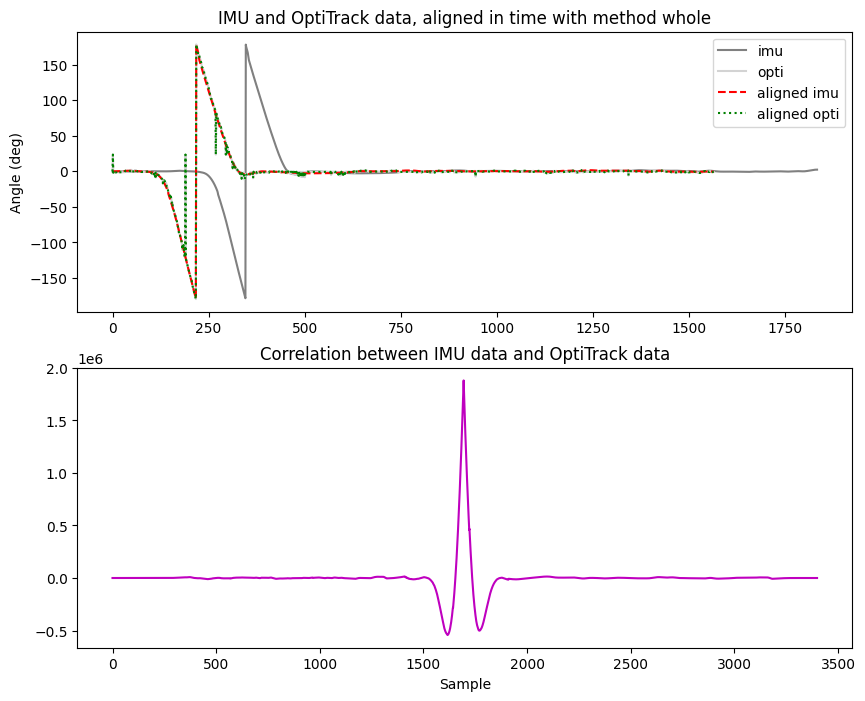

In [11]:
# Time align data
aligned_imu_data, aligned_opti_data = mf.prepocess_and_align_data(resampled_imu_data=resampled_imu_data, 
                                                                  opti_data=opti_data, preproces_method = 'ta_first', 
                                                                  time_align_method=time_alignment_method, flipped_fix=True, align_plot=True)

In [12]:
# Compute trunk tilt (z-axis deviation from vertical)
# Rotation matrix data from dataframes
plot_R_imu = np.stack(aligned_imu_data[rigid_body]['pr_rot_matrix'])
plot_R_opti = np.stack(aligned_opti_data[rigid_body]['pr_rot_matrix'])

# Calculate Euler opti angles and MAD filter
euler_opti = R.from_matrix(plot_R_opti).as_euler('XYZ', degrees=True)

# Calculate the tilt angles
tilt_angles_imu = np.array([mf.tilt_angles(R_matrix, degrees=True) for R_matrix in plot_R_imu])
tilt_angles_opti = np.array([mf.tilt_angles(R_matrix, degrees=True) for R_matrix in plot_R_opti])

# Flipped fix???
if (subject, test_name, speed, rigid_body) in flipped_combinations:
    first_non_zero_angle = tilt_angles_opti[np.nonzero(tilt_angles_opti)[0][0]]
    first_non_zero_angle_imu = tilt_angles_imu[np.nonzero(tilt_angles_imu)[0][0]]
    tilt_angles_opti = first_non_zero_angle_imu + abs(tilt_angles_opti - first_non_zero_angle) 

# Offset fix
if (subject, test_name, speed, rigid_body) in offset_combinations:
    mean_tilt_angles_opti = np.mean(tilt_angles_opti)
    tilt_angles_opti = abs(tilt_angles_opti - mean_tilt_angles_opti)

# Ensure they are the same length
assert len(tilt_angles_imu) == len(tilt_angles_opti), "Angle lists must be the same length."

# Filter outliers from residuals and final_angles for imu and opti
mask, final_residuals = mf.remove_residual_outliers(tilt_angles_imu, tilt_angles_opti, method='iqr')
final_angles_imu = tilt_angles_imu[mask]
final_angles_opti = tilt_angles_opti[mask]

### Trunk Tilt Angle Visualization

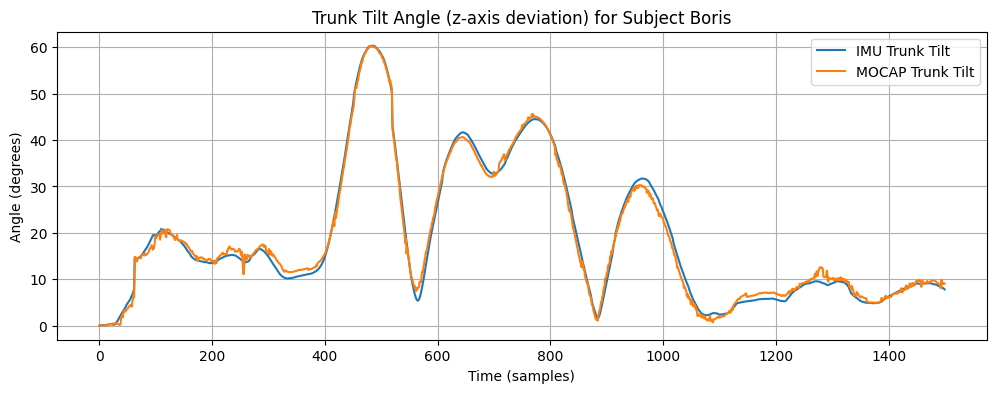

In [13]:
plt.figure(figsize=(12, 4))
plt.plot(final_angles_imu, label='IMU Trunk Tilt')
plt.plot(final_angles_opti, label='MOCAP Trunk Tilt')
plt.title(f'Trunk Tilt Angle (z-axis deviation) for Subject {subject}')
plt.xlabel('Time (samples)')
plt.ylabel('Angle (degrees)')
plt.legend()
plt.grid(True)
plt.show()

### Raw mag and gyro data

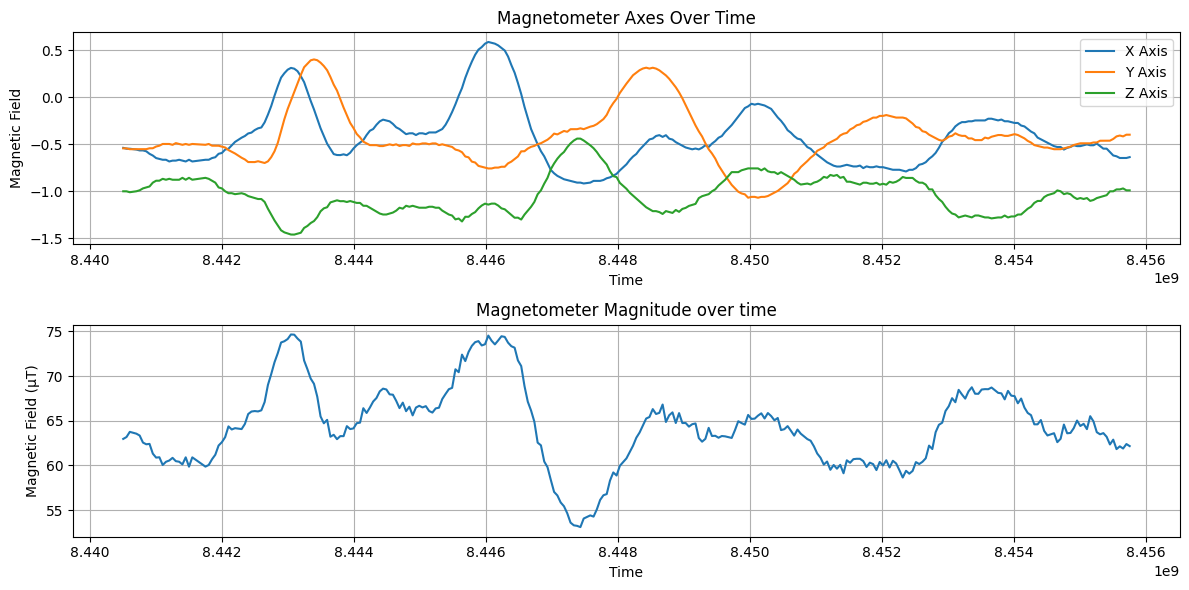

In [14]:
imu_mag_data, fs_mag = mf.load_mag_imu_data(imu_folder)

# Plot each magnetic axis (x, y, z) over time separately
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6))

ax1.plot(imu_mag_data[rigid_body]['Timestamp (us)'], imu_mag_data[rigid_body]['X (a.u.)'], label='X Axis')
ax1.plot(imu_mag_data[rigid_body]['Timestamp (us)'], imu_mag_data[rigid_body]['Y (a.u.)'], label='Y Axis')
ax1.plot(imu_mag_data[rigid_body]['Timestamp (us)'], imu_mag_data[rigid_body]['Z (a.u.)'], label='Z Axis')
ax2.plot(imu_mag_data[rigid_body]['Timestamp (us)'], imu_mag_data[rigid_body]['magnitude'], label = 'Magnitude')

ax1.set_title("Magnetometer Axes Over Time")
ax1.set_xlabel("Time")
ax1.set_ylabel("Magnetic Field")
ax1.legend()
ax1.grid(True)

ax2.set_title("Magnetometer Magnitude over time")
ax2.set_xlabel("Time")
ax2.set_ylabel("Magnetic Field (µT)")
ax2.grid(True)

plt.tight_layout()
plt.show()

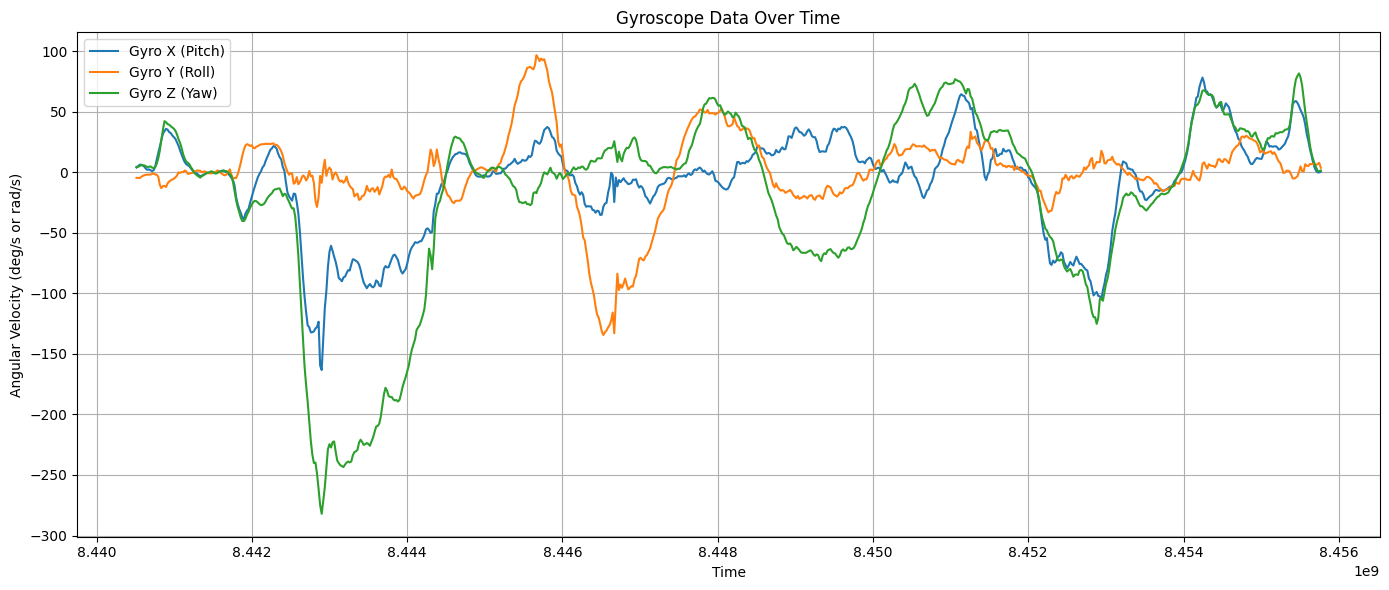

In [15]:
imu_gyro_data, fs_gyro = mf.load_gyro_imu_data(imu_folder)

plt.figure(figsize=(14, 6))
plt.plot(imu_gyro_data[rigid_body]['Timestamp (us)'], imu_gyro_data[rigid_body]['Gyroscope X (deg/s)'], label='Gyro X (Pitch)', linewidth=1.5)
plt.plot(imu_gyro_data[rigid_body]['Timestamp (us)'], imu_gyro_data[rigid_body]['Gyroscope Y (deg/s)'], label='Gyro Y (Roll)', linewidth=1.5)
plt.plot(imu_gyro_data[rigid_body]['Timestamp (us)'], imu_gyro_data[rigid_body]['Gyroscope Z (deg/s)'], label='Gyro Z (Yaw)', linewidth=1.5)

plt.title('Gyroscope Data Over Time')
plt.xlabel('Time')
plt.ylabel('Angular Velocity (deg/s or rad/s)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Main Validation Analysis

In [ ]:
# Run full analysis
summary_df, validation_df, imu_all, opti_all = mf.aggregate_metrics(subjects_all, subjects_pro, tests, speeds, rigid_bodies, dir, test_date, test_date_amateur)

Time shift = 33 samples
Time shift = 33 samples
Time shift = 33 samples
Time shift = -51 samples
Time shift = -51 samples
Time shift = -51 samples
Time shift = 76 samples
Time shift = 76 samples
Time shift = 76 samples
Time shift = -243 samples
Time shift = -243 samples
Time shift = -243 samples
Time shift = 49 samples
Time shift = 49 samples
Time shift = 49 samples
Time shift = 15 samples
Time shift = 15 samples
Time shift = 15 samples
Time shift = 67 samples
Time shift = 67 samples
Time shift = 67 samples
Time shift = -12 samples
Time shift = -12 samples
Time shift = -12 samples
Time shift = 40 samples
Time shift = 40 samples
Time shift = 40 samples
Time shift = 126 samples
Time shift = 126 samples
Time shift = 126 samples
Time shift = 168 samples
Time shift = 168 samples
Time shift = 168 samples
Time shift = 107 samples
Time shift = 107 samples
Time shift = 107 samples
Time shift = -86 samples
Time shift = -86 samples
Time shift = -86 samples
Time shift = 100 samples
Time shift = 10

## Normality Tests for IMU and MOCAP Trunk Tilt Angles

Normality Results for back
IMU: p=0.0000, skew=1.43, kurtosis=1.88
OPTI: p=0.0000, skew=1.42, kurtosis=1.84
RESIDUALS: p=0.0000, skew=-2.74, kurtosis=77.60
Bland-Altman results: bias = -0.0812770642874589, LoA = 4.3530691911479-4.3530691911479, std = 2.2624215588955914


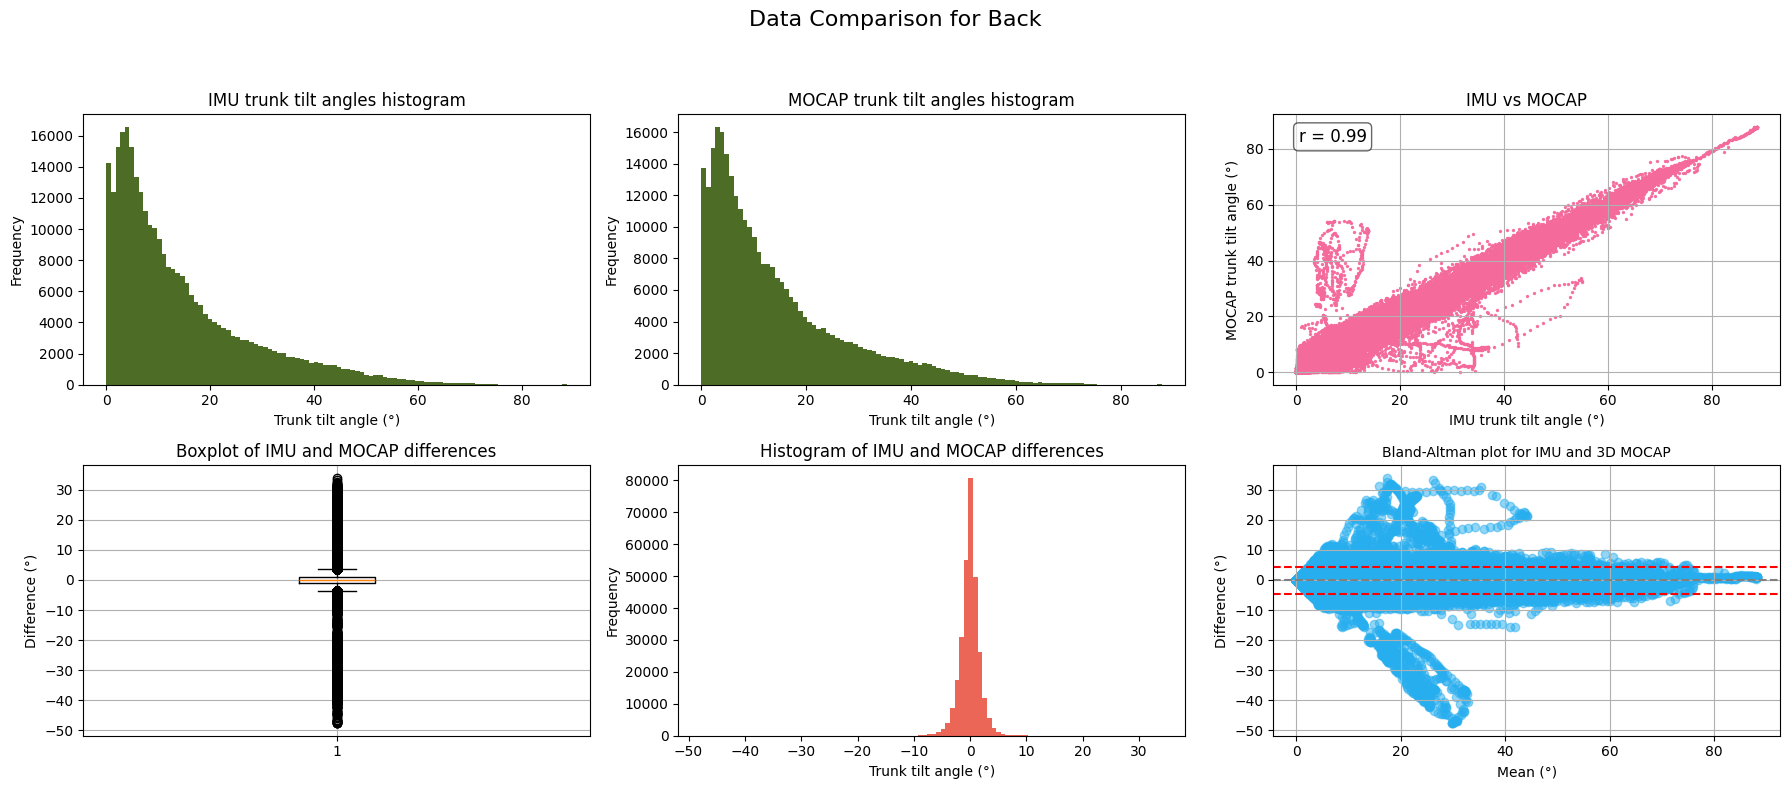

In [ ]:
mf.normality_check_plot(imu_all, opti_all, rigid_body='back')

## Export Results

In [ ]:
summary_df.to_excel('trunk_summary_metrics.xlsx', index=False)
validation_df.to_excel('trunk_validation_metrics.xlsx', index=False)